# Play sound

In [5]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
def binarize_letter(x):
    i = ord(x)
    assert 0 < i < 128
    return list("{:07b}".format(i))

def frequentize_letter(x, n=7, mid=3, base=1):
    bits = binarize_letter(x)
    assert len(bits) == n
    return [base * (2 ** (i - mid)) for i, bit in enumerate(bits) if bit == "1"]

def frequentize(s):
    return [frequentize_letter(x) for x in list(s)]

frequentize("Hello world!")

[[0.125, 1],
 [0.125, 0.25, 2, 8],
 [0.125, 0.25, 1, 2],
 [0.125, 0.25, 1, 2],
 [0.125, 0.25, 1, 2, 4, 8],
 [0.25],
 [0.125, 0.25, 0.5, 2, 4, 8],
 [0.125, 0.25, 1, 2, 4, 8],
 [0.125, 0.25, 0.5, 4],
 [0.125, 0.25, 1, 2],
 [0.125, 0.25, 2],
 [0.25, 8]]

In [4]:
def make_waveform(freqs_sets, duration, base_freq=440, sample_rate=44100, base_amplitude=0.5):
    # Generate time axis
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Generate waveform
    waveform = base_amplitude * np.concatenate([
        np.sum(
            [np.sin(2 * np.pi * freq * base_freq * t) for freq in freqs],
            axis=0
        )
        for freqs in freqs_sets
    ])

    return waveform

def play_waveform(waveform, sample_rate=44100):    
    # Play sound
    sd.play(waveform, sample_rate)
    
    # Wait for the sound to finish playing
    sd.wait()

sampling_freq = 44100
wf = make_waveform(frequentize("Hello world!"), 0.2, sample_rate=sampling_freq)

sf.write("tmp_wave.wav", wf, samplerate=sampling_freq)

# Example usage: Play a 440 Hz tone for 2 seconds
play_waveform(wf)

# Analyze optimal .wav

In [11]:
wf, sampling_freq = sf.read("tmp_wave.wav")
play_waveform(wf, sample_rate=sampling_freq)

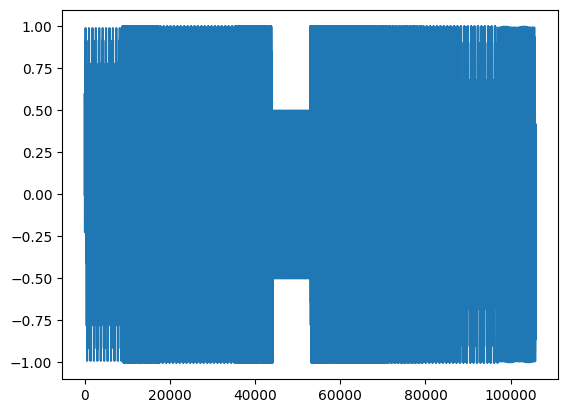

In [12]:
# plot waveform on y-axis, with x-axis being index
fig, ax = plt.subplots()
ax.plot(wf)
plt.show()

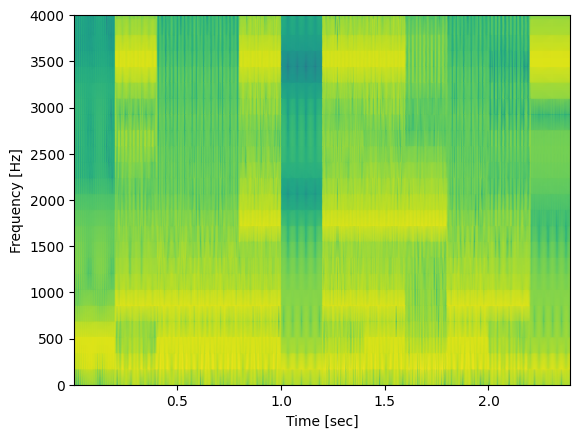

In [13]:
f, t, Sxx = scipy.signal.spectrogram(wf, fs=sampling_freq)
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 4000)
plt.show()

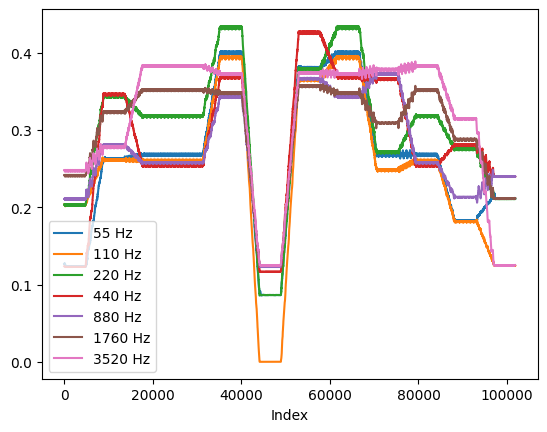

In [138]:
def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

# def extract_signal(wf, target_freq, bandwidth=5, sampling_freq=44100, N=2):
#     low_cutoff = (target_freq - bandwidth / 2) / (sampling_freq / 2)
#     high_cutoff = (target_freq + bandwidth / 2) / (sampling_freq / 2)
#     b, a = scipy.signal.butter(N=N, Wn=[low_cutoff, high_cutoff], btype='bandpass')
#     return scipy.signal.lfilter(b, a, wf)

# def extract_signal(wf, target_freq, rp=1, rs=40, sampling_freq=44100):
#     normalized_frequency = target_freq / (sampling_freq / 2)
#     N, Wn = scipy.signal.ellipord(wp=normalized_frequency, ws=normalized_frequency + 0.05, gpass=rp, gstop=rs, fs=sampling_freq)
#     # b, a = scipy.signal.ellip(N, rp, rs, Wn, btype='bandpass')
#     sos = scipy.signal.ellip(N, rp, rs, Wn, btype='bandpass', output='sos')
#     return scipy.signal.sosfilt(sos, wf)

def extract_signal(wf, target_freq, quality=1, sampling_freq=44100):
    b, a = scipy.signal.iirnotch(target_freq, quality, sampling_freq)
    return scipy.signal.lfilter(b, a, wf)

freqs = [55, 110, 220, 440, 880, 1760, 3520]

for freq in freqs:
    s = extract_signal(wf, freq)
    y = moving_average(s ** 2, 4000)
    plt.plot(y)

plt.xlabel('Index')
plt.legend([f'{freq} Hz' for freq in freqs])
plt.show()

# Record sound

In [105]:
freq = 44100
duration = 7
recording = sd.rec(int(duration * freq), samplerate=freq, channels=1)
sd.wait()

recording

array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-3.0517578e-05],
       ...,
       [ 4.2724609e-03],
       [ 4.5166016e-03],
       [ 4.7607422e-03]], dtype=float32)

In [106]:
sd.play(recording, samplerate=freq)

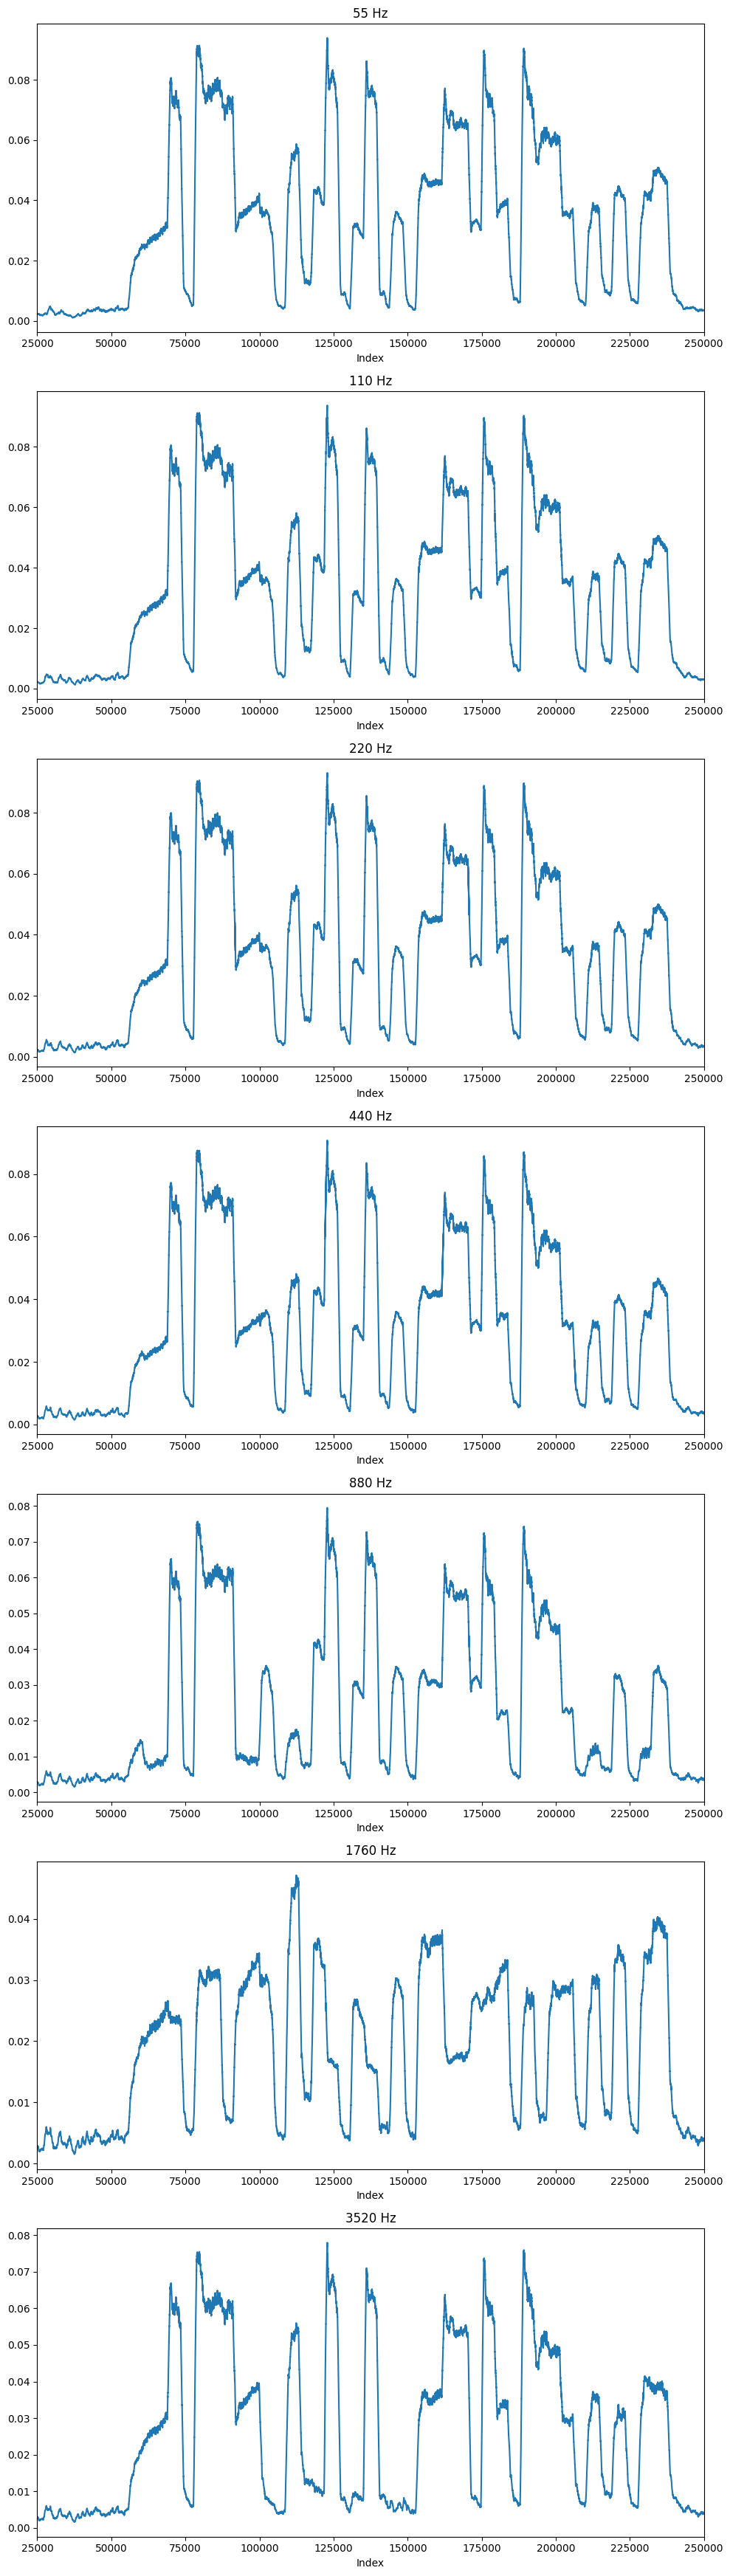

In [145]:
fig, axs = plt.subplots(len(freqs), 1, figsize=(10, 5 * len(freqs)))

for i, freq in enumerate(freqs):
    s = extract_signal(recording[:, 0], freq, quality=1)
    y = moving_average(np.abs(s), 1000)
    axs[i].plot(y)
    axs[i].set_xlabel('Index')
    axs[i].set_xlim(25e3, 250e3)
    axs[i].set_title(f'{freq} Hz')

plt.tight_layout()
plt.show()